In [56]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

import torch
torch.set_float32_matmul_precision('high')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# Import the relevant modules
import numpy as np
import figs.utilities.config_helper as ch
import figs.utilities.transform_helper as th
import sousvide.utilities.sousvide_utilities as svu
import sousvide.visualize.plot_3D as p3d

from figs.simulator import Simulator
from figs.tsplines.min_time_snap import MinTimeSnap
from figs.control.vehicle_rate_uqp import VehicleRateUQP
from figs.control.vehicle_rate_mpc import VehicleRateMPC

In [74]:
# course = ch.get_config("robustness_track","courses")
# course = ch.get_config("bounce1","courses")
course = ch.get_config("line","courses")
gsplat = ch.get_gsplat("mid_gate")
method = ch.get_config("eval_single","methods")
frame = ch.get_config("carl","frames")

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/mid_gate/splatfacto/2024-10-07_145741/nerfstudio_models/step-000029999.ckpt

In [ ]:
sim = Simulator(gsplat,method["rollout"],frame,course["forces"])

In [75]:
policy = ch.get_config("vrmpc_fr","pilots")
mpc = VehicleRateMPC(policy,course,frame)

tXUd = mpc.tXUd
x0 = tXUd[1:11,0]
obj = svu.tXU_to_obj(tXUd)

In [65]:
policy = ch.get_config("vrfqp_fr_v2","pilots")
uqp = VehicleRateUQP(policy,course,frame)

/home/admin/anaconda3/envs/kitchen/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [76]:
mts = MinTimeSnap(course["waypoints"],100,20)
Tskf,FOkf = mts.get_ideal(None)

/home/admin/anaconda3/envs/kitchen/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [77]:
mu = np.zeros((4,5))
std = np.array([
    [ 0.40, 0.40, 0.40, 0.20, 0.20],
    [ 0.40, 0.40, 0.40, 0.20, 0.20],
    [ 0.40, 0.40, 0.40, 0.20, 0.20],
    [ 0.20, 0.20, 0.20, 0.10, 0.10],
])

/home/admin/anaconda3/envs/kitchen/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


[3.791787312012761, 3.566840412461036, 3.342226003213549, 3.507893054404359, 3.648427076129287, 3.5701515531958563, 3.5760351078279506, 3.586311409675137, 3.7798772131064093, 3.4412130946718946]


/home/admin/Personal/Kitchen/src/sousvide/visualize/plot_3D.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


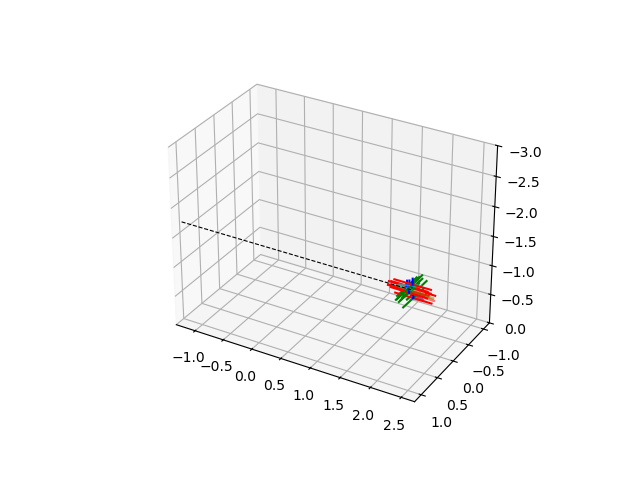

In [82]:
np.random.seed(0)
tXUs,dTs = [],[]
for i in range(10):
    # Generate perturbed state
    W = 0.1*np.random.normal(mu,std)
    
    FO1 = FOkf[1,:,:] + W
    FO2 = FOkf[1,:,:]
    FO = np.concatenate((FO1[None,:,:],FO2[None,:,:]),axis=0)

    # Solve
    dT,Pn = mts.solve(FO)

    # Generate trajectory
    t0,tf = Tskf[0],Tskf[1]
    Ts = np.linspace(t0,tf,100)
    tXU = th.dTPn_to_tXU(Ts,dT,Pn,1.0,7.0)

    dTs.append(dT[0])
    tXUs.append(tXU)

print(dTs)
p3d.tXU_to_3D(tXUs,tXUd=tXUd)